# 🛍️ Product Affinity-Based Customer Segmentation

This notebook uses K-Means clustering to segment retail customers based on their purchase behavior across different product categories. The insights can help with marketing personalization, bundling strategies, and loyalty planning.


## Data Loading and Preprocessing

In [19]:
#Load the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
#load dataset
df = pd.read_excel('Online Retail.xlsx')

In [3]:
#Explore data
print(df.info)
print(df.describe)
df.head()

<bound method DataFrame.info of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Cust

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
#check for missing values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [7]:
#Cleaning the data
# Drop rows where CustomerID is missing (since we need to segment by customer)
df = df.dropna(subset=['CustomerID'])

# Optional: Drop rows where Description is missing (only needed for product-level analysis)
df = df.dropna(subset=['Description'])

# Reset index after dropping
df = df.reset_index(drop=True)

# Check final shape
print(f"Rows remaining after cleaning: {df.shape[0]}")

Rows remaining after cleaning: 406829


In [13]:
#Creating RFM table
# Snapshot date = one day after the last invoice
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
# Create TotalPrice as Quantity × UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

#Group by customer id
rfm = df.groupby('CustomerID').agg(
    {
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    }
).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display the result
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [15]:
#Standardize features before clustering

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


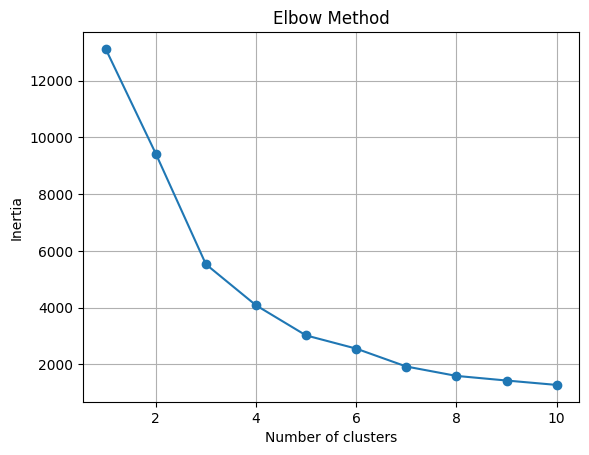

In [17]:
#Determine Optimal K
inertia = []
for k in range(1,11):
  model = KMeans(n_clusters=k, random_state=42)
  model.fit(rfm_scaled)
  inertia.append(model.inertia_)

plt.plot(range(1,11),inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

### Elbow Method Interpretation

This plot shows the relationship between the **number of clusters (k)** and the **inertia** (within-cluster sum of squares). As `k` increases, inertia decreases — but not always significantly.

---

### Key Observations:

* There is a **steep drop** in inertia from **k = 1 to k = 4**, indicating that adding clusters up to this point substantially improves the compactness of clusters.
* After **k = 4**, the rate of improvement slows — the curve **starts to flatten**.
* From **k = 6 onward**, the improvements in inertia are minimal.

---

### Optimal Number of Clusters:

The **“elbow point” appears at `k = 4` or `k = 5`** — where the rate of inertia reduction slows significantly.

This means:

* Using 4 or 5 clusters provides a good balance between **model simplicity** and **segmentation quality**.
* More than 5 clusters likely leads to **diminishing returns** in clustering performance.

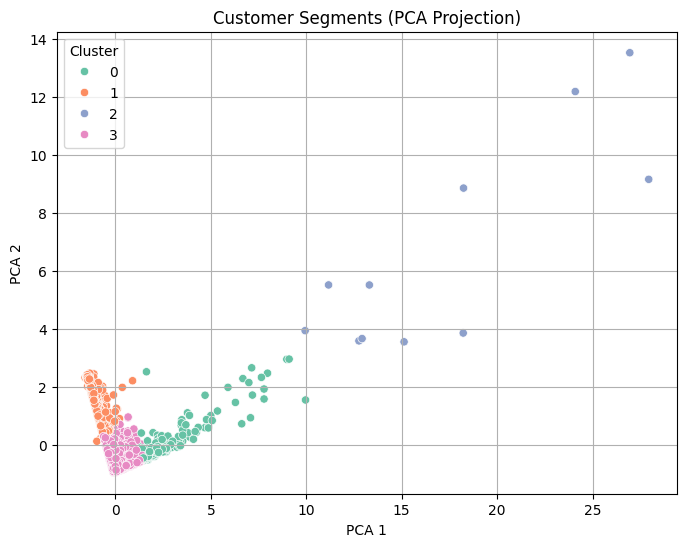

In [20]:
#Visualize with PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm['Cluster'], palette='Set2')
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


### Interpretation of PCA-Based Customer Segments (k = 4)

This PCA plot visualizes customer clusters derived from K-Means applied to RFM data (Recency, Frequency, Monetary). Each point represents a customer, and the colors indicate the assigned cluster.

#### **Cluster 0**

* Centrally located with moderate spread
* Represents customers with average purchase behavior in terms of frequency, spending, and recency
* Likely the baseline group for typical customer activity

#### **Cluster 1**

* Tight grouping near Cluster 0
* Likely contains customers who purchase frequently and recently, with moderate monetary value
* Represents consistent and potentially loyal customers

#### **Cluster 2**

* Spread out and distant from other clusters along PCA axis 1
* Likely high-spending customers with distinct purchase patterns (e.g., large orders or frequent high-value purchases)
* This cluster represents the most valuable segment in terms of monetary contribution

#### **Cluster 3**

* Compact and located on the edge of the cluster group
* Likely consists of infrequent buyers with low spending and longer time since the last purchase
* Represents a segment with low engagement or dormant users


In [18]:
#Fit kmeans model
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# View segment profiles
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

,Recency,Frequency,Monetary
Cluster,,,
0,10.8,28.5,12168.3
1,248.9,1.8,455.1
2,5.1,109.9,124312.3
3,42.8,4.4,1321.0


### 📊 Cluster Summary Interpretation

| Cluster | Recency ↓ | Frequency ↑ | Monetary ↑ | Segment Type             | Interpretation                                        |
| ------- | --------- | ----------- | ---------- | ------------------------ | ----------------------------------------------------- |
| **2**   | 5.1       | 109.9       | 124,312.3  | **Best Customers**       | Very recent, very frequent, extremely high spenders.  |
| **0**   | 10.8      | 28.5        | 12,168.3   | **Loyal, High-Spending** | Active and frequent, moderately high spenders.        |
| **3**   | 42.8      | 4.4         | 1,321.0    | **Potential Loyalists**  | Recent buyers with low frequency and modest spending. |
| **1**   | 248.9     | 1.8         | 455.1      | **At-Risk / Churned**    | Long inactive, low purchase frequency, low spending.  |

---

### Business Actions

#### **Cluster 2** — Best Customers

* Maintain with personalized offers, early access, VIP perks

#### **Cluster 0** — Loyal, High-Value

* Encourage with loyalty rewards, upsell premium bundles

#### **Cluster 3** — Potential Loyalists

* Re-engage with reminders, product recommendations, or incentives

#### **Cluster 1** — At Risk

* Target with win-back campaigns, limited-time discounts, or feedback requests

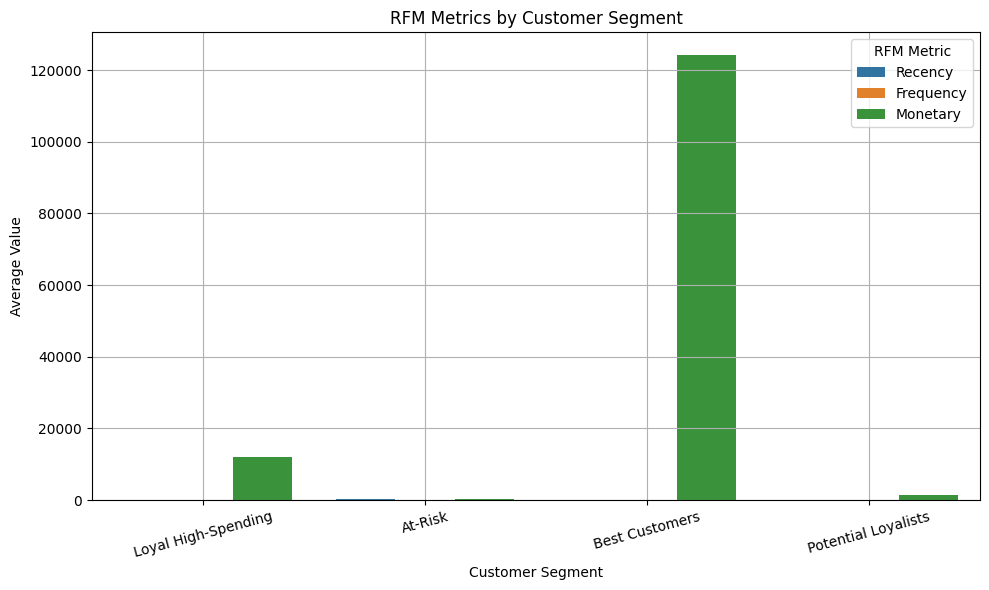

In [21]:
# Manually create RFM values and clusters
rfm_summary = pd.DataFrame({
    'Cluster': [0, 1, 2, 3],
    'Recency': [10.8, 248.9, 5.1, 42.8],
    'Frequency': [28.5, 1.8, 109.9, 4.4],
    'Monetary': [12168.3, 455.1, 124312.3, 1321.0]
})

# Map segments to cluster IDs
segment_labels = {
    0: "Loyal High-Spending",
    1: "At-Risk",
    2: "Best Customers",
    3: "Potential Loyalists"
}

rfm_summary["Segment"] = rfm_summary["Cluster"].map(segment_labels)

# Melt the DataFrame for plotting
rfm_melted = pd.melt(rfm_summary,
                     id_vars=["Segment"],
                     value_vars=["Recency", "Frequency", "Monetary"],
                     var_name="Metric",
                     value_name="AverageValue")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Segment", y="AverageValue", hue="Metric", data=rfm_melted)
plt.title("RFM Metrics by Customer Segment")
plt.ylabel("Average Value")
plt.xlabel("Customer Segment")
plt.xticks(rotation=15)
plt.legend(title="RFM Metric")
plt.grid(True)
plt.tight_layout()
plt.show()

 **RFM metrics visualization** for each customer segment based on clustering results.

### 🧾 Summary of Insights:

#### **Best Customers (Cluster 2)**

* Lowest recency → very recent buyers
* Highest frequency and monetary → extremely engaged and high value
* **Action**: Maintain loyalty through VIP treatment, early access, or exclusive offers

#### **Loyal High-Spending (Cluster 0)**

* Also recent and frequent, with solid spend
* **Action**: Encourage continued purchases via loyalty programs and upselling

#### **Potential Loyalists (Cluster 3)**

* Moderate recency, low frequency and spending
* **Action**: Provide incentives or personalized recommendations to increase engagement

#### **At-Risk (Cluster 1)**

* High recency (inactive), very low frequency and monetary
* **Action**: Launch win-back campaigns or request feedback to re-engage